In [1]:
!pip install osmnx
!pip install matplotlib
!pip install geopandas
!pip install folium
!pip install scikit-learn

In [2]:
import folium
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
from folium.plugins import MarkerCluster
from shapely.geometry import MultiPoint, Polygon
from shapely.ops import unary_union
from sklearn.cluster import DBSCAN
import numpy as np
from shapely.geometry import Point

/var/folders/vz/b1smgzt13_dbs5c1rbj4m3dh0000gn/T/ipykernel_23407/1648654384.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  bus_stops = ox.geometries_from_place(place_name, tags=tags)


380


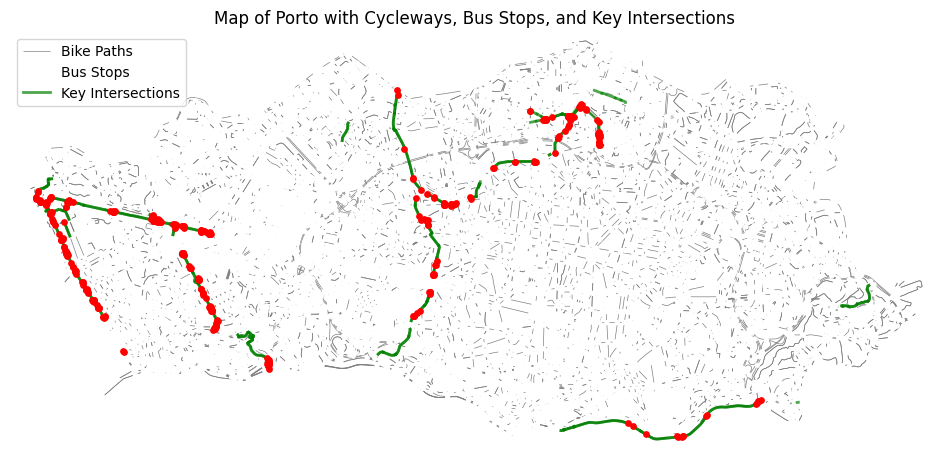

In [17]:
def is_bike_friendly(edge):
    return (
        edge.get('bicycle', 'no') in ('yes', 'designated', 'permissive') or
        edge.get('highway') == 'cycleway' or
        'cycleway' in edge
    )

# Define the place and create a graph from OSM data
place_name = "Porto, Portugal"
G = ox.graph_from_place(place_name, network_type='all')

# Get bus stops and bike-friendly paths
tags = {'highway': 'bus_stop'}
bus_stops = ox.geometries_from_place(place_name, tags=tags)

# Get the edges from the graph
gdfs = ox.graph_to_gdfs(G, nodes=False)
edges = gdfs[0] if isinstance(gdfs, tuple) else gdfs
bike_friendly_edges = edges[edges.apply(is_bike_friendly, axis=1)]

# Extract nodes (intersections) and convert to the same CRS
intersections = ox.graph_to_gdfs(G, nodes=True, edges=False)
intersections = intersections[0].to_crs('EPSG:3395') if isinstance(intersections, tuple) else intersections.to_crs('EPSG:3395')

# Convert bus stops and bike paths to the same CRS and create buffers
bus_stops = bus_stops.to_crs('EPSG:3395')
bus_stops_buffer = bus_stops.buffer(50)  # 100 meters buffer for bus stops
bike_friendly_edges = bike_friendly_edges.to_crs('EPSG:3395')
bike_friendly_buffer = bike_friendly_edges.buffer(20)  # 20 meters buffer for bike paths

# Find intersections near bus stops
near_bus_stops = intersections[intersections.geometry.apply(lambda x: bus_stops_buffer.contains(x).any())]

# Find intersections near bike paths
near_bike_paths = intersections[intersections.geometry.apply(lambda x: bike_friendly_buffer.contains(x).any())]

# Find intersections that are both near bus stops and bike paths
near_both = near_bus_stops[near_bus_stops.index.isin(near_bike_paths.index)]

# Convert back to the original CRS for plotting
G = ox.project_graph(G, to_crs='EPSG:4326')
near_both = near_both.to_crs('EPSG:4326')
print(len(near_both))
# Plotting
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(G, ax=ax, show=False, close=False, edge_color='gray', edge_linewidth=0.5)

# Plot bike-friendly paths
for geometry in bike_friendly_edges.to_crs('EPSG:4326')['geometry']:
    x, y = geometry.xy
    ax.plot(x, y, color='green', linewidth=2, alpha=0.7)

# Highlight intersections near both bus stops and bike paths
near_both.plot(ax=ax, color='red', markersize=15, zorder=3)

ax.set_title("Map of Porto with Cycleways, Bus Stops, and Key Intersections")
plt.legend(['Bike Paths', 'Bus Stops', 'Key Intersections'])
plt.show()
